<p style="text-align: center; font-size: 35px;"><b>Social Media Management</b></p>
<p style="margin-top: -20px; text-align: center; font-size: 27px;"><b>Final Project</b></p>
<p style="margin-top: -10px; text-align: center; font-size: 18px;"><b>Basic Classifiers Benchmark for Climate Change Tweets</b></p>
<p style="text-align: center; font-size: 16px;"><a href="https://linktr.ee/antonioscardace">Antonio Scardace</a> • 1000007272 • April 2022</p>

## Introduction to Project Idea and Dataset
This task consists, given a series of tweets about Climate Change, in figuring out whether the user (the author) is skeptic or supports the belief of man-made climate change. Once implemented, trained, and tested, this algorithm will be useful in some real contests.

To solve this problem, I have made a model (a classifier) which has been trained on a **43943 tweets** dataset collected between 2015-04-27 and 2018-02-21 by ***Canada Foundation for Innovation JELF Grant to Chris Bauch, University of Waterloo***. <br/>
Each row of the dataset contains: the text of the tweet labelled as '*message*', the tweet id labelled as '*tweetid*', and the sentiment of the tweet labelled as '*sentiment*'.

Each sentiment is labelled as one of the following classes:
- ``-1`` (**Anti**) &#8594; the tweet author doesn't believe in man-made climate change;
- ``0`` (**Neutral**) &#8594; the tweet author neither supports nor refutes the belief of man-made climate change;
- ``1`` (**Pro**) &#8594; the tweet author supports the belief of man-made climate change;
- ``2`` (**News**) &#8594; the tweet links to factual news about climate change;

Let's see how classes are distributed in the dataset. It is unbalanced.<br/>
<img src="imgs/dataset_distribution.png" alt="dataset distribution" style="width: 550px; margin-top: 10px; border: 1px solid #555"/>

## Base Code

I had to import all the modules I needed:
- ``numpy`` adds support for big arrays and matrices, along with a large collection of math functions.
- ``pandas`` helps with data manipulation and analysis through charts and tables.
- ``matplotlib`` is a comprehensive library for creating static, animated, and interactive visualizations. I used it to get a colormap.
- ``re`` provides Regular Expression matching operations.
- ``vaderSentiment`` is a lexicon and rule-based sentiment-analysis tool which is sensitive to web-based media texts.
- ``sklearn`` is a library for Machine Learning on Python.

Through ``sklearn`` I have imported some methods and classes. Let's see some of them:
- **SVC** &#8594; implements SVC (Support Vector Classifier) which is an implementation of SVM (Support Vector Machine).
- **GridSearchCV** &#8594; it provides methods to optimize parameters into the algorithm (such as K in KNN algorithm).
- **ShuffleSplit** &#8594; for large datasets it is used to improve the work of GridSearchCV bypassing the Cross-Validation.
- **CountVectorizer** &#8594; converts a collection of text documents to a matrix of token counts.
- **TfidfTransformer** &#8594; transforms a count matrix to a normalized tf or tf-idf representation.
- **Pipeline** &#8594; sequentially applies a list of operations and a final estimator (classifier, in our case). Implements methods to train and test our algorithm.

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import re
import vaderSentiment.vaderSentiment

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from sklearn.metrics import ConfusionMatrixDisplay

I have implemented this **preprocessing** function ``pre_proc`` using **Regular Expressions** (RegEx). <br/>
It is a method useful to remove links inside the tweets text, because they confuse the classifier in multiple ways. <br/>
For instance: in the dataset there may be a tweet (of sentiment **J**) containing just an image (represented by a link). Since there is no text to analyze, the classifier will associate a priori each time a tweet consisting of only a link appears, the output class **J**.

In [5]:
def pre_proc(doc):
    return re.sub(r"(?:\@|https?\://)\S+", "", doc).replace('RT ', '')

## Dataset Loading

As first thing, I have needed to load the dataset from a CSV file.

In [6]:
tweets = pd.read_csv('dataset.csv')
tweets.pop('tweetid')
tweets.head()

,sentiment,message
0,-1,@tiniebeany climate change is an interesting h...
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...
3,1,RT @Mick_Fanning: Just watched this amazing do...
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ..."


## Experimental Dataset

**As a test** I have extracted and added as features also the sentiment of each tweet thanks to **VADER**. <br/>
Each sentiment returned from VADER is composed by **four scores**: negative, neutral, positive, and compound (is a normalized metric).

In [7]:
vader = vaderSentiment.vaderSentiment.SentimentIntensityAnalyzer()

tweets['neg'], tweets['neu'], tweets['pos'], tweets['com'] = 0, 0, 0, 0
idx = 0

for tweet in tweets.iterrows():
    sentiment = vader.polarity_scores(pre_proc(tweet[1]['message']))

    tweets.loc[idx, 'neg'] = sentiment['neg'] * 100
    tweets.loc[idx, 'neu'] = sentiment['neu'] * 100
    tweets.loc[idx, 'pos'] = sentiment['pos'] * 100
    tweets.loc[idx, 'com'] = sentiment['compound'] * 100

    idx += 1

tweets.head()

,sentiment,message,neg,neu,pos,com
0,-1,@tiniebeany climate change is an interesting h...,8.1,62.2,29.7,64.28
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,0.0,100.0,0.0,0.00
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,0.0,54.4,45.6,85.44
3,1,RT @Mick_Fanning: Just watched this amazing do...,0.0,74.3,25.7,67.05
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",15.6,73.6,10.8,-27.32


I have tested this dataset with each pipeline and each algorithm. Here is an example with the pipeline of KNN algorithm. <br/>
Unfortunately, as you can see below, this new version of the dataset did not bring better results to the model. On the contrary, it made them worse than the KNN algorithm that you can find [below in the project](#comparison-of-classification-algorithms). <br/>
So, in addition to this, I have obtained just a more complex model: bigger space and time complexity. For these reasons, I didn't use it.

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin # they allow us to extend fit and transform methods by our features
from sklearn.pipeline import FeatureUnion # allows us to work with multiple features
from sklearn.preprocessing import MaxAbsScaler # normalizes features in a range [0, 1]

In [9]:
class NumberSelector(BaseEstimator, TransformerMixin):

    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

class TextSelector(BaseEstimator, TransformerMixin):

    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

In [10]:
knn_exp = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('selector', TextSelector(key='message')),
            ('vect', CountVectorizer(stop_words=None, strip_accents=None, lowercase=True, max_df=0.75, preprocessor=pre_proc)),
            ('tfidf', TfidfTransformer(use_idf=False)),
            ('standard', MaxAbsScaler())
        ])),
        ('pos', Pipeline([
            ('selector', NumberSelector(key='pos')),
            ('standard', MaxAbsScaler())
        ])),
        ('neg', Pipeline([
            ('selector', NumberSelector(key='neg')),
            ('standard', MaxAbsScaler())
        ])),
        ('neu', Pipeline([
            ('selector', NumberSelector(key='neu')),
            ('standard', MaxAbsScaler())
        ])),
        ('com', Pipeline([
            ('selector', NumberSelector(key='com')),
            ('standard', MaxAbsScaler())
        ]))
    ])),
    ('classifier', KNeighborsClassifier(n_neighbors=1, weights='uniform'))
])

F1 score for KNN on experimental dataset:  [28.44984802 38.66377977 47.22510912 55.62962963]
Accuracy score for KNN on experimental dataset:  44.62565425168778


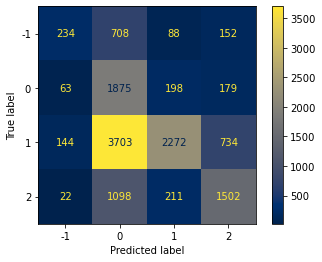

In [47]:
x_tr_exp, x_te_exp, y_tr_exp, y_te_exp = train_test_split(
    tweets[['message', 'neg', 'neu', 'pos', 'com']], 
    tweets['sentiment'], test_size=0.3 
)

knn_exp.fit(x_tr_exp, y_tr_exp)
knn_exp_predict = knn_exp.predict(x_te_exp)

ConfusionMatrixDisplay.from_predictions(y_te_exp, knn_exp_predict, cmap=plt.cm.cividis)

print('F1 score for KNN on experimental dataset: ', f1_score(y_te_exp, knn_exp_predict, average=None) * 100)
print('Accuracy score for KNN on experimental dataset: ', accuracy_score(y_te_exp, knn_exp_predict) * 100)

## Splitting Dataset

I have splitted the dataset into Training Set (TR), and Test Set (TE). Respectively in 85%, and 15%. <br/>
[Later](#comparison-of-classification-algorithms), from the Training Set will be extracted the Validation Set (VA)(15%).  

In [12]:
np.random.seed()

x_tr, x_te, y_tr, y_te = train_test_split(tweets['message'], tweets['sentiment'], test_size=0.15)

print('Training Set Length:', len(x_tr))
print('Test Set Length:', len(x_te))

Training Set Length: 37351
Test Set Length: 6592


## Comparison of Classification Algorithms

I have chosen five algorithms: ``K-Nearest Neighbors``, ``Multinomial Naive-Bayes``, ``Logistic Regression``, ``SVM``, and ``SGD-Classifier``. <br/>
``K-Nearest Neighbors`` and ``SVM`` are an easy geometric approach and a more complex one to classification. <br/>
``Multinomial Naive-Bayes`` and ``Logistic Regression`` are an easy probabilistic approach and a more complex one to classification. <br/>
``SGD-Classifier`` implements linear algorithms (both geometric and probabilistic) and optimizes them with SGD (Stochastic Gradient Descent).

I have made five different pipelines: one for each algorithm. <br/>
In each Pipeline I have set three main steps:
- _vect_ &#8594; **CountVectorizer** &#8594; converts a collection of documents (tweets) to a matrix of token counts (Bag-of-Words). It takes this list of parameters:
    - *stop_words* &#187; Removes some very common words (based on English vocabulary).
    - *strip_accents* &#187; Removes accents and any other not supported characters (for instance, Arabic symbols are not supported in ASCII).
    - *lowercase* &#187; Converts all characters to lowercase.
    - *max_df* &#187; When building the vocabulary ignores terms that have a document frequency strictly higher than the given threshold.
- _tfidf_ &#8594; **TfidfTransformer** &#8594; transforms a count matrix to a normalized tf-idf representation (common term weighting scheme in information retrieval). It takes this list of parameters:
    - *use_idf* &#187; Enable inverse-document-frequency reweighting. If False, idf(t) = 1.
- _clf_ &#8594; is the algorithm used for classification.

For each pipeline, for each step, there are some parameters which have been set thanks to experience with ``GridSearchCV``. <br/>
*GridSearchCV* uses **Cross-Validation**. But it has been designed to work on limited dataset (and it is not our case). This just slows us down. <br/>
To solve this problem, I have set the parameter *'cv'* using **ShuffleSplit()**, which gets the **Validation Set (15%)** from the TR, and lets the process of Cross-validation repeat just once (instead of 5 times) optimizing the execution time. 

**N.B.** Before running these codes, I suggest you to set in each _GridSearchCV_ the parameter *n_jobs* with the number of your cores - 2. <br/>
**N.B.** Before running these codes, assume that the entire run will last **about 5 hours** instead of **25 hours** (without ShuffleSplit).

#### **K-Nearest Neighbors Algorithm**

In this case, the classifier takes two parameters:
- *n_neighbors* &#187; Number of closest examples to consider during classification. It is usually called *K parameter*.
- *weights* &#187; Weight function used in prediction.
    - *'uniform'* : uniform weights. All points in each neighborhood are weighted equally.
    - *'distance'* : weight points by the inverse of their distance. In this case, closer neighbors will have a greater influence than neighbors which are further away. 

In [13]:
knn_va_classifier = Pipeline([
    ('vect', CountVectorizer(preprocessor=pre_proc)),
    ('tfidf', TfidfTransformer()),
    ('clf', KNeighborsClassifier())
])

params = {
    'vect__stop_words': (None, 'english'),
    'vect__strip_accents': (None, 'unicode'),
    'vect__lowercase': [True, False],
    'vect__max_df': [0.125, 0.25, 0.375, 0.5, 0.75, 0.875, 1.0],
    'tfidf__use_idf': (True, False),
    'clf__n_neighbors': np.arange(1, 11),
    'clf__weights': ['uniform', 'distance'],
}
knn_gs = GridSearchCV(knn_va_classifier, params, cv=ShuffleSplit(test_size=0.1765, n_splits=1), n_jobs=4)

knn_gs.fit(x_tr, y_tr)

print('Use Stop-Words-Removal: ', knn_gs.best_params_['vect__stop_words'])
print('Remove Accents: ', knn_gs.best_params_['vect__strip_accents'])
print('Lowercase: ', knn_gs.best_params_['vect__lowercase'])
print('Max-df: ', knn_gs.best_params_['vect__max_df'])
print('Use TF-IDF: ', knn_gs.best_params_['tfidf__use_idf'])
print('Best K parameter: ', knn_gs.best_params_['clf__n_neighbors'])
print('Weight function used in prediction: ', knn_gs.best_params_['clf__weights'])

Use Stop-Words-Removal:  None
Remove Accents:  None
Lowercase:  True
Max-df:  0.75
Use TF-IDF:  False
Best K parameter:  1
Weight function used in prediction:  uniform


F1 score for KNN on TE:  [29.58199357 40.60987415 58.41350517 63.90804598]
Accuracy score for KNN on TE:  51.88106796116505


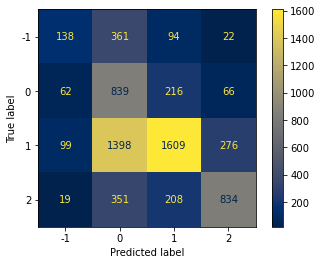

In [34]:
knn_classifier = Pipeline([
    ('vect', CountVectorizer(
        stop_words=knn_gs.best_params_['vect__stop_words'],
        strip_accents=knn_gs.best_params_['vect__strip_accents'],
        lowercase=knn_gs.best_params_['vect__lowercase'],
        max_df=knn_gs.best_params_['vect__max_df'],
        preprocessor=pre_proc,
    )),
    ('tfidf', TfidfTransformer(use_idf=knn_gs.best_params_['tfidf__use_idf'])),
    ('clf', KNeighborsClassifier(n_neighbors=knn_gs.best_params_['clf__n_neighbors'], weights=knn_gs.best_params_['clf__weights']))
])

knn_classifier.fit(x_tr, y_tr)
knn_predict = knn_classifier.predict(x_te)

ConfusionMatrixDisplay.from_predictions(y_te, knn_predict, cmap=plt.cm.cividis)

print('F1 score for KNN on TE: ', f1_score(y_te, knn_predict, average=None) * 100)
print('Accuracy score for KNN on TE: ', accuracy_score(y_te, knn_predict) * 100)

#### **Multinomial Naive-Bayes Algorithm**

In this case, the classifier takes zero parameters: &#8709;

In [35]:
nb_va_classifier = Pipeline([
    ('vect', CountVectorizer(preprocessor=pre_proc)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

params = {
    'vect__stop_words': (None, 'english'),
    'vect__strip_accents': (None, 'unicode'),
    'vect__lowercase': [True, False],
    'vect__max_df': [0.125, 0.25, 0.375, 0.5, 0.75, 0.875, 1.0],
    'tfidf__use_idf': (True, False)
}
nb_gs = GridSearchCV(nb_va_classifier, params, cv=ShuffleSplit(test_size=0.1765, n_splits=1), n_jobs=4)

nb_gs.fit(x_tr, y_tr)

print('Use Stop-Words-Removal: ', nb_gs.best_params_['vect__stop_words'])
print('Remove Accents: ', nb_gs.best_params_['vect__strip_accents'])
print('Lowercase: ', nb_gs.best_params_['vect__lowercase'])
print('Max-df: ', nb_gs.best_params_['vect__max_df'])
print('Use TF-IDF: ', nb_gs.best_params_['tfidf__use_idf'])

Use Stop-Words-Removal:  english
Remove Accents:  None
Lowercase:  True
Max-df:  0.125
Use TF-IDF:  True


F1 score for MultinomialNB on TE:  [ 8.97832817 15.27777778 72.72727273 56.5967366 ]
Accuracy score for MultinomialNB on TE:  61.33191747572816


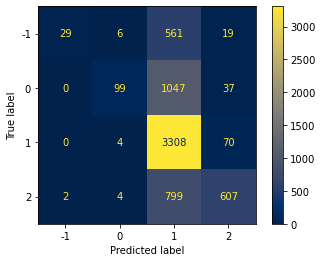

In [36]:
nb_classifier = Pipeline([
    ('vect', CountVectorizer(
        stop_words=nb_gs.best_params_['vect__stop_words'],
        strip_accents=nb_gs.best_params_['vect__strip_accents'],
        lowercase=nb_gs.best_params_['vect__lowercase'],
        max_df=nb_gs.best_params_['vect__max_df'],
        preprocessor=pre_proc
    )),
    ('tfidf', TfidfTransformer(use_idf=nb_gs.best_params_['tfidf__use_idf'])),
    ('clf', MultinomialNB())
])

nb_classifier.fit(x_tr, y_tr)
nb_predict = nb_classifier.predict(x_te)

ConfusionMatrixDisplay.from_predictions(y_te, nb_predict, cmap=plt.cm.cividis)

print('F1 score for MultinomialNB on TE: ', f1_score(y_te, nb_predict, average=None) * 100)
print('Accuracy score for MultinomialNB on TE: ', accuracy_score(y_te, nb_predict) * 100)

#### **Logistic Regression Algorithm**

In this case, the classifier takes two parameters:
- *max_iter* &#187; Maximum number of iterations taken for the solvers to converge.
- *solver* &#187; Algorithm to use in the optimization problem. It depends on dataset size, and on the number of possible output classes.

In [37]:
lr_va_classifier = Pipeline([
    ('vect', CountVectorizer(preprocessor=pre_proc)),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression())
])

params = {
    'vect__stop_words': (None, 'english'),
    'vect__strip_accents': (None, 'unicode'),
    'vect__lowercase': [True, False],
    'vect__max_df': [0.125, 0.25, 0.375, 0.5, 0.75, 0.875, 1.0],
    'tfidf__use_idf': (True, False),
    'clf__max_iter': (600, 700, 800),
    'clf__solver': ['liblinear', 'sag', 'saga', 'lbfgs']
}
lr_gs = GridSearchCV(lr_va_classifier, params, cv=ShuffleSplit(test_size=0.1765, n_splits=1), n_jobs=4)

lr_gs.fit(x_tr, y_tr)

print('Use Stop-Words-Removal: ', lr_gs.best_params_['vect__stop_words'])
print('Remove Accents: ', lr_gs.best_params_['vect__strip_accents'])
print('Lowercase: ', lr_gs.best_params_['vect__lowercase'])
print('Max-df: ', lr_gs.best_params_['vect__max_df'])
print('Use TF-IDF: ', lr_gs.best_params_['tfidf__use_idf'])
print('Maximum number of iterations taken to converge: ', lr_gs.best_params_['clf__max_iter'])
print('Algorithm to use in the optimization problem: ', lr_gs.best_params_['clf__solver'])

Use Stop-Words-Removal:  None
Remove Accents:  None
Lowercase:  True
Max-df:  0.375
Use TF-IDF:  True
Maximum number of iterations taken to converge:  600
Algorithm to use in the optimization problem:  saga


F1 score for LogisticRegressor on TE:  [46.799117   48.90473765 79.08574448 73.63437728]
Accuracy score for LogisticRegressor on TE:  71.2378640776699


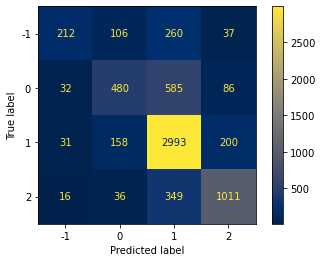

In [38]:
lr_classifier = Pipeline([
    ('vect', CountVectorizer(
        stop_words=lr_gs.best_params_['vect__stop_words'],
        strip_accents=lr_gs.best_params_['vect__strip_accents'],
        lowercase=lr_gs.best_params_['vect__lowercase'],
        max_df=lr_gs.best_params_['vect__max_df'],
        preprocessor=pre_proc
    )),
    ('tfidf', TfidfTransformer(use_idf=lr_gs.best_params_['tfidf__use_idf'])),
    ('clf', LogisticRegression(max_iter=lr_gs.best_params_['clf__max_iter'], solver=lr_gs.best_params_['clf__solver']))
])

lr_classifier.fit(x_tr, y_tr)
lr_predict = lr_classifier.predict(x_te)

ConfusionMatrixDisplay.from_predictions(y_te, lr_predict, cmap=plt.cm.cividis)

print('F1 score for LogisticRegressor on TE: ', f1_score(y_te, lr_predict, average=None) * 100)
print('Accuracy score for LogisticRegressor on TE: ', accuracy_score(y_te, lr_predict) * 100)

#### **Support-Vector-Machine (SVM) Algorithm**

In this case, the classifier takes one parameter:
- *kernel* &#187; Specifies the kernel type to be used in the algorithm which return a "best fit" hyperplane which divides (categorizes) data.

In [40]:
svm_va_classifier = Pipeline([
    ('vect', CountVectorizer(preprocessor=pre_proc)),
    ('tfidf', TfidfTransformer()),
    ('clf', SVC())
])

params = {
    'vect__stop_words': (None, 'english'),
    'vect__strip_accents': (None, 'unicode'),
    'vect__lowercase': [True, False],
    'vect__max_df': [0.125, 0.25, 0.375, 0.5, 0.75, 0.875, 1.0],
    'tfidf__use_idf': (True, False),
    'clf__kernel': ('linear', 'rbf')
}
svm_gs = GridSearchCV(svm_va_classifier, params, cv=ShuffleSplit(test_size=0.1765, n_splits=1), n_jobs=4)

svm_gs.fit(x_tr, y_tr)

print('Use Stop-Words-Removal: ', svm_gs.best_params_['vect__stop_words'])
print('Remove Accents: ', svm_gs.best_params_['vect__strip_accents'])
print('Lowercase: ', svm_gs.best_params_['vect__lowercase'])
print('Max-df: ', svm_gs.best_params_['vect__max_df'])
print('Use TF-IDF: ', svm_gs.best_params_['tfidf__use_idf'])
print('Kernel type used: ', svm_gs.best_params_['clf__kernel'])

Use Stop-Words-Removal:  None
Remove Accents:  None
Lowercase:  True
Max-df:  0.375
Use TF-IDF:  True
Kernel type used:  linear


F1 score for SVM on TE:  [52.11122554 49.95044599 79.39671425 74.53954496]
Accuracy score for SVM on TE:  71.85983009708737


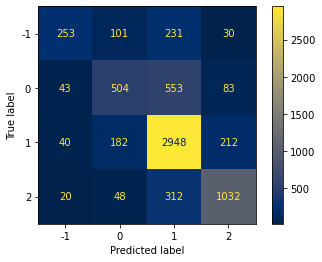

In [41]:
svm_classifier = Pipeline([
    ('vect', CountVectorizer(
        stop_words=svm_gs.best_params_['vect__stop_words'],
        strip_accents=svm_gs.best_params_['vect__strip_accents'],
        lowercase=svm_gs.best_params_['vect__lowercase'],
        max_df=svm_gs.best_params_['vect__max_df'],
        preprocessor=pre_proc
    )),
    ('tfidf', TfidfTransformer(use_idf=svm_gs.best_params_['tfidf__use_idf'])),
    ('clf', SVC(kernel=svm_gs.best_params_['clf__kernel']))
])

svm_classifier.fit(x_tr, y_tr)
svm_predict = svm_classifier.predict(x_te)

ConfusionMatrixDisplay.from_predictions(y_te, svm_predict, cmap=plt.cm.cividis)

print('F1 score for SVM on TE: ', f1_score(y_te, svm_predict, average=None) * 100)
print('Accuracy score for SVM on TE: ', accuracy_score(y_te, svm_predict) * 100)

#### **SGD (Stochastic Gradient Descent)**

In this case, the classifier takes zero parameters: &#8709;

In [42]:
sgd_va_classifier = Pipeline([
    ('vect', CountVectorizer(preprocessor=pre_proc)),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier())
])

params = {
    'vect__stop_words': (None, 'english'),
    'vect__strip_accents': (None, 'unicode'),
    'vect__lowercase': [True, False],
    'vect__max_df': [0.125, 0.25, 0.375, 0.5, 0.75, 0.875, 1.0],
    'tfidf__use_idf': (True, False)
}
sgd_gs = GridSearchCV(sgd_va_classifier, params, cv=ShuffleSplit(test_size=0.1765, n_splits=1), n_jobs=4)

sgd_gs.fit(x_tr, y_tr)

print('Use Stop-Words-Removal: ', sgd_gs.best_params_['vect__stop_words'])
print('Remove Accents: ', sgd_gs.best_params_['vect__strip_accents'])
print('Lowercase: ', sgd_gs.best_params_['vect__lowercase'])
print('Max-df: ', sgd_gs.best_params_['vect__max_df'])
print('Use TF-IDF: ', sgd_gs.best_params_['tfidf__use_idf'])

Use Stop-Words-Removal:  None
Remove Accents:  unicode
Lowercase:  True
Max-df:  0.75
Use TF-IDF:  True


F1 score for SGD on TE:  [39.90384615 41.14149822 77.80738485 70.77805665]
Accuracy score for SGD on TE:  69.25060679611651


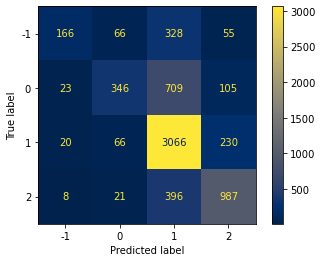

In [43]:
sgd_classifier = Pipeline([
    ('vect', CountVectorizer(
        stop_words=sgd_gs.best_params_['vect__stop_words'],
        strip_accents=sgd_gs.best_params_['vect__strip_accents'],
        lowercase=sgd_gs.best_params_['vect__lowercase'],
        max_df=sgd_gs.best_params_['vect__max_df'],
        preprocessor=pre_proc
    )),
    ('tfidf', TfidfTransformer(use_idf=sgd_gs.best_params_['tfidf__use_idf'])),
    ('clf', SGDClassifier())
])

sgd_classifier.fit(x_tr, y_tr)
sgd_predict = sgd_classifier.predict(x_te)

ConfusionMatrixDisplay.from_predictions(y_te, sgd_predict, cmap=plt.cm.cividis)

print('F1 score for SGD on TE: ', f1_score(y_te, sgd_predict, average=None) * 100)
print('Accuracy score for SGD on TE: ', accuracy_score(y_te, sgd_predict) * 100)

## Conclusions

I have tested and compared five basic classification algorithms.<br/>
The best is SVM (**accuracy = 71.8%**), followed in order by Logistic Regression, SGD, K-Nearest Neighbors, and Multinomial Naive-Bayes. <br/>

* The model works well just with tweets which are really about climate change. If they contain humorism, the model doesn't work well.
* It is "quick" and was useful for introduce me into Machine Learning world.

## Bibliography

All info about sklearn classes and functions have been taken from: [scikit-learn.org](https://scikit-learn.org/stable/index.html). <br/>
Dataset and idea have been taken from: [kaggle.com/edqian/twitter-climate-change-sentiment-dataset](https://www.kaggle.com/datasets/edqian/twitter-climate-change-sentiment-dataset).